In [209]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astroduet.bbmag import bb_abmag_fluence
from astroduet.image_utils import construct_image, find, ap_phot, run_daophot
from astroduet.config import Telescope
from astroduet.background import background_pixel_rate
from astroduet.utils import duet_abmag_to_fluence
from astropy.table import Table
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astroduet.diff_image import py_zogy
from astroduet.image_utils import estimate_background

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
duet = Telescope()
[bgd_band1, bgd_band2] = background_pixel_rate(duet, low_zodi = True, diag=True)
print(duet.read_noise)

-----
Background Computation Integrating over Pixel Area
Telescope diameter: 26.0 cm
Transmission Efficiency: 0.8166518036622619


Pixel Size: 6.4 arcsec
Pixel Area: 40.96000000000001 arcsec2

Zodi Level: 77
Band1 Rate: 0.030369732491096913 ph / s
Band2 Rate: 0.2478588509265617 ph / s
-----
7


/Users/mheida/software/miniconda2/envs/duet/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [211]:
hdu_ref20 = fits.open('../astroduet/data/image_library/tel_best/gal_spiral/zodi_low/duet1/best_duet1_spiral_20.0_zodi-low_reference.fits')
hdu_ref21 = fits.open('../astroduet/data/image_library/tel_best/gal_spiral/zodi_low/duet1/best_duet1_spiral_21.0_zodi-low_reference.fits')

hdu_im20 = fits.open('../astroduet/data/image_library/tel_best/gal_spiral/zodi_low/duet1/best_duet1_spiral_20.0_zodi-low_src-19.80.fits')
hdu_im21 = fits.open('../astroduet/data/image_library/tel_best/gal_spiral/zodi_low/duet1/best_duet1_spiral_21.0_zodi-low_src-20.80.fits')

In [212]:
image_rate = hdu_im20[1].data / hdu_im20[1].header['EXPTIME'] *u.ph / u.s
ref_image_rate = hdu_ref20[2].data / hdu_ref20[2].header['EXPTIME'] *u.ph / u.s

In [230]:
# New (1D) background estimation
image_bkg_new, image_bkg_rms_median_new = estimate_background(image_rate, method='1D', sigma=2)
ref_bkg_new, ref_bkg_rms_median_new = estimate_background(ref_image_rate, method='1D', sigma=2)
image_rate_bkgsub_new, ref_rate_bkgsub_new = image_rate - image_bkg_new, ref_image_rate - ref_bkg_new
print(image_bkg_rms_median_new)

0.025343850912321955 ph / s


In [231]:
# Old (2D) background estimation
image_bkg_old, image_bkg_rms_median_old = estimate_background(image_rate, method='2D', sigma=4)
ref_bkg_old, ref_bkg_rms_median_old = estimate_background(ref_image_rate, method='2D', sigma=4)
image_rate_bkgsub_old, ref_rate_bkgsub_old = image_rate - image_bkg_old, ref_image_rate - ref_bkg_old
print(image_bkg_rms_median_old)

0.9984391927492652 ph / s


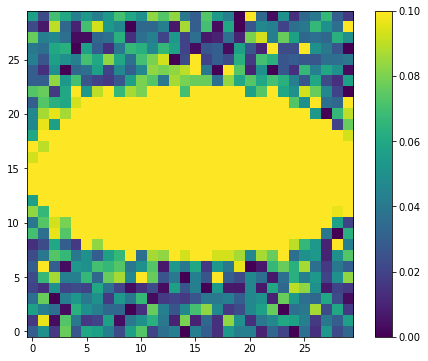

In [244]:
plt.figure(figsize=[8,6])
plt.imshow(image_rate.value, cmap='viridis', aspect=1, origin='lower', vmin=0, vmax=0.1)
plt.colorbar()

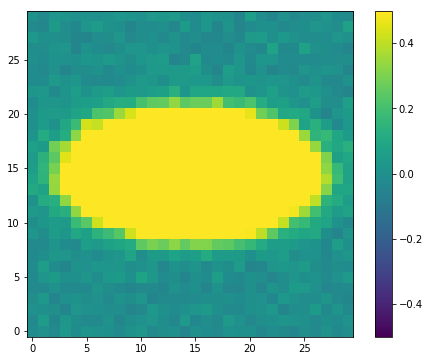

In [245]:
plt.figure(figsize=[8,6])
plt.imshow(image_rate_bkgsub_new.value, cmap='viridis', aspect=1, origin='lower', vmin=-0.5, vmax=0.5)
plt.colorbar()

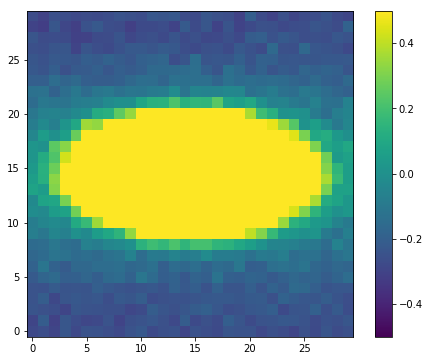

In [246]:
plt.figure(figsize=[8,6])
plt.imshow(image_rate_bkgsub_old.value, cmap='viridis', aspect=1, origin='lower', vmin=-0.5, vmax=0.5)
plt.colorbar()

In [248]:
# Make a 2D array containing the PSF (oversample then bin up for more accurate PSF)

oversample = 5
pixel_size_init = duet.pixel / oversample

psf_model = duet.psf_model(pixel_size=pixel_size_init, x_size=25, y_size=25)

psf_os = psf_model.array

#psf_os = gaussian_psf(psf_fwhm,(25,25),pixel_size_init)
shape = (5, 5, 5, 5)
psf_array = psf_os.reshape(shape).sum(-1).sum(1)

# Use ZOGY algorithm to create difference image
s_n, s_r = np.sqrt(image_rate), np.sqrt(ref_image_rate) # 2D uncertainty (sigma) - that is, noise on the background
sn, sr = np.mean(s_n), np.mean(s_r) # Average uncertainty (sigma)
dx, dy = 0.1, 0.01 # Astrometric uncertainty (sigma)
diff_image_new, d_psf2_new, s_corr2_new = py_zogy(image_rate_bkgsub_new.value,
                                    ref_rate_bkgsub_new.value,
                                    psf_array,psf_array,
                                    s_n.value,s_r.value,
                                    sn.value,sr.value,dx,dy)

diff_image_old, d_psf_old, s_corr_old = py_zogy(image_rate_bkgsub_old.value,
                                    ref_rate_bkgsub_old.value,
                                    psf_array,psf_array,
                                    s_n.value,s_r.value,
                                    sn.value,sr.value,dx,dy)


diff_image_new *= image_rate_bkgsub_new.unit
diff_image_old *= image_rate_bkgsub_old.unit

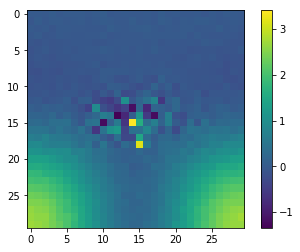

In [249]:
plt.imshow(diff_image_old.value)
plt.colorbar()
plt.show()

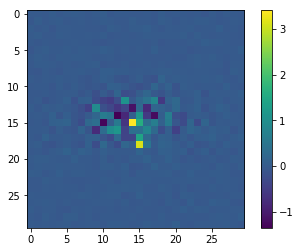

In [250]:
plt.imshow(diff_image_new.value)
plt.colorbar()
plt.show()

In [251]:
diff_bkg, sky = estimate_background(diff_image_old, method='1D', sigma=5)
print(sky)

0.7523678220992591 ph / s


In [256]:
diff_bkg, sky = estimate_background(diff_image_old, method='2D', sigma=5)
print(sky)

0.2766124159980973 ph / s


In [253]:
diff_bkg, sky = estimate_background(diff_image_new, method='1D', sigma=5)
print(sky)

0.06343894178349443 ph / s


In [254]:
diff_bkg, sky = estimate_background(diff_image_new, method='2D', sigma=5)
print(sky)

0.06725160030596686 ph / s


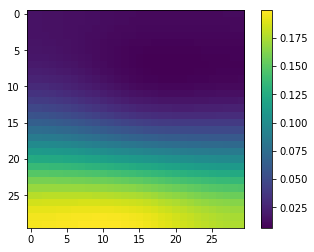

In [257]:
plt.imshow(diff_bkg.value)
plt.colorbar()
plt.show()